In [8]:
from scipy import integrate
import math
from collections import deque
import random
def simulate(trafficLoad=0.2):
    tl = 5
    tb = 40
    M = 5
    mu = 25
    N = 10
    lamda = trafficLoad * mu
    hour = 50

    packetArrival = deque()
    cur = 0
    while cur < 1000 * 60 * 60 * hour * 1.1:
        nxt = random.expovariate(1/(1/lamda*1000))
        cur += nxt
        packetArrival.append(cur)

    buffer = deque()
    cnt = 0
    totalWait = 0
    sleepState = 0
    cur = 0
    while cur < 60 * 60 * 1000 * hour:
        cur += tb * (2 ** sleepState) + tl
        while packetArrival[0] <= cur:
            buffer.append(packetArrival.popleft())
            if len(buffer) > N:
                buffer.pop()
        if len(buffer) == 0:
            sleepState = min(sleepState+1, M)
        else:
            while len(buffer) != 0:
                cnt += 1
                cur += 1000 / mu
                totalWait += cur - buffer.popleft()
                while packetArrival[0] <= cur:
                    buffer.append(packetArrival.popleft())
                    if len(buffer) > N:
                        buffer.pop()
            sleepState = 0
    return totalWait / cnt

In [9]:
import math
import numpy as np
def theoretical_calculate(trafficLoad=0.2):
    mu = 0.025
    Ev = 1/mu
    lamda = mu * trafficLoad
    M = 5
    N = 10
    Tb = 40
    Tl = 5
    
    T = [0] * (M+1)
    for i in range(M+1):
        T[i] = 2 ** i * Tb + Tl
        
    beta = [0] * (M+1)
    for i in range(M+1):
        beta[i] = math.exp(-lamda*T[i])
        
    alpha = [[0] * (N+1) for _ in range(M+1)]
    for i in range(M+1):
        for j in range(1, N+1):
            if j <= N-1:
                alpha[i][j] = ((lamda*T[i])**j*math.exp(-lamda*T[i]))/(math.factorial(j)*(1-beta[i]))
            else:
                alpha[i][j] = 1-sum(alpha[i][:-1])
                
    beta_multiply = [0] * (M+1)
    beta_multiply[0] = beta[0]
    for i in range(1, M+1):
        beta_multiply[i] = beta_multiply[i-1] * beta[i]
        
    p = [[0] * (N+1) for _ in range(M+1)]

    p[0][0] = 1/(1+sum(((2-beta[i])*beta_multiply[i-1]) for i in range(1,M))+(2-beta[M])/(1-beta[M])*beta_multiply[M-1])
    for i in range(M+1):
        for j in range(N+1):
            if 0 <= i <= M-1 and j == 0:
                p[i+1][j] = beta[i]*p[i][0]
            elif i == M and j == 0:
                p[i][j] = beta[M-1]*(1-beta[M])*p[M-1][0]
            else:
                p[i][j] = (1-beta[i])*p[i][0]*alpha[i][j]
                
    Tm = [[0] * (N+1) for _ in range(N+1)]
    for j in range(N+1):
        for k in range(N+1):
            if j <= k+1 and k < N:
                Tm[j][k] = math.pow(lamda*Ev, k-j+1)/math.factorial(k-j+1)*math.exp(-lamda*Ev)
            elif k == N:
                Tm[j][k] = 1 - sum(Tm[j][:-1])
            else:
                Tm[j][k] = 0
                
    To = [[0] * 1 for _ in range(N+1)]
    To[1][0] = math.exp(-lamda*Ev)
    
    c = [0] * (N+1)
    for j in range(1, N+1):
        E = [0] * (N+1)
        E[j] = 1
        for k in range(1, 10000):
            c[j] += k * ((np.array(E)[1:]) * (np.mat(np.array(Tm)[1:,1:])**(k-1)) * (np.array(To)[1:,0:])).item(0,0)
            
    d = [[0] * (N+1) for _ in range(M+1)]
    for i in range(M+1):
        for j in range(1,N+1):
            d[i][j] = 1/c[j]*(j*(T[i]+(j+1)*Ev)/2+(c[j]-j)*(c[j]-j+1)*Ev/2)
            
    numerator, denominator = 0, 0
    for i in range(M+1):
        tNumerator, tDenominator = 0, 0
        for j in range(1, N+1):
            tNumerator += alpha[i][j] * c[j] * d[i][j]
            tDenominator += alpha[i][j] * c[j]
        tNumerator *= p[i][0] * (1-beta[i])
        tDenominator *= p[i][0] * (1-beta[i])
        numerator += tNumerator
        denominator += tDenominator
    D = numerator / denominator
    return D


In [11]:
theoretical_calculate_D = []
simulate_D = []
for trafficLoad in range(1, 81):
    print(trafficLoad/100)
    theoretical_calculate_D.append(theoretical_calculate(trafficLoad/100))
    print("theoretical_calculate: ", theoretical_calculate_D[-1])
    sm = 0
    for i in range(100):
        sm += simulate(trafficLoad/100)
    simulate_D.append(sm/100)
    print("simulate: ", simulate_D[-1])    

0.01
theoretical_calculate:  332.7659705051869
simulate:  575.0450760886048
0.02
theoretical_calculate:  350.8125215313421
simulate:  501.0703882119363
0.03
theoretical_calculate:  349.15320187239485
simulate:  445.0481743475717
0.04
theoretical_calculate:  338.2960199086292
simulate:  400.5727566014402
0.05
theoretical_calculate:  322.83147033678017
simulate:  363.73651818157776
0.06
theoretical_calculate:  305.24482611451737
simulate:  332.6640039222502
0.07
theoretical_calculate:  287.04657957311053
simulate:  305.9182960426043
0.08
theoretical_calculate:  269.1883268114768
simulate:  283.02629396494484
0.09
theoretical_calculate:  252.25220988396123
simulate:  263.05780826483965
0.1
theoretical_calculate:  236.5607967715059
simulate:  245.70558662376476
0.11
theoretical_calculate:  222.25448832207272
simulate:  230.52529181726857
0.12
theoretical_calculate:  209.35095249864813
simulate:  217.48907193438998
0.13
theoretical_calculate:  197.79084144977583
simulate:  205.9701199145026

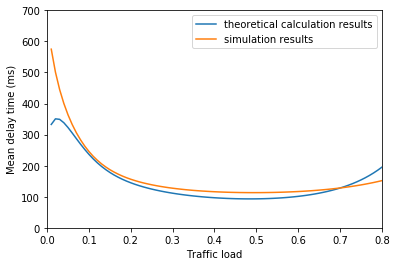

In [20]:
import matplotlib.pyplot as plt
l1, = plt.plot([i/100 for i in range(1, 81)], theoretical_calculate_D)
l2, = plt.plot([i/100 for i in range(1, 81)], simulate_D)
plt.axis([0, 0.8, 0, 700])
plt.legend(handles=[l1,l2],labels=['theoretical calculation results','simulation results'],loc='best')
plt.xlabel('Traffic load')
plt.ylabel('Mean delay time (ms)')
plt.show()